In [1]:
# Do not change this cell
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

num_classes = 4
num_features = 2
random_seed = 1

# Create dataset
X, y = make_blobs(n_samples=10000, n_features=num_features, centers=num_classes, 
                  cluster_std=1.5, random_state=random_seed)

# Convert to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [169]:
# TODO: you will design your model here
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()
        self.input_layer = torch.nn.Linear(input_size, 8)
        self.dense_1 = torch.nn.Linear(8, 16)
        self.dense_2 = torch.nn.Linear(16, 16)
        self.dense_3 = torch.nn.Linear(16, 8)
        self.output = torch.nn.Linear(8, output_size)
        self.act=torch.nn.ReLU()
        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.dense_1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.dense_2(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.dense_3(x)
        x = self.act(x)
        x = self.output(x)
        return x

In [171]:
def train_step(model, X_train, y_train, loss_fn, optimizer, device):
    # TODO: implement one epoch of training
    X_train, y_train = X_train.to(device), y_train.to(device)
    model.train()
    y_pred = model(X_train).squeeze()
    train_loss = loss_fn(y_pred,y_train)
    optimizer.zero_grad
    train_loss.backward()
    optimizer.step()
    with torch.no_grad():
        y_pred_labels = torch.argmax(y_pred, dim=1)
    correct = torch.eq(y_pred_labels, y_train).sum().item()
    train_acc = (correct / len(y_train)) * 100
    return train_loss.item(), train_acc

In [173]:
def evaluation_step(model, X_test, y_test, loss_fn, device):
    # TODO: implement evaluation on test set
    X_test, y_test = X_test.to(device), y_test.to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        test_loss = loss_fn(y_pred, y_test)
        y_pred_labels = torch.argmax(y_pred, dim=1)
        correct = torch.eq(y_pred_labels, y_test).sum().item()
        test_acc = (correct / len(y_test)) * 100
    return test_loss.item(), test_acc

In [175]:
def train_simple_model(X_train, y_train, X_test, y_test, random_seed):
    # Make device
    device = "cpu" 
    if torch.cuda.is_available(): 
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps" 
    
    torch.manual_seed(random_seed) # do not change this

    # TODO: write codes to train your model here
    epochs = 4501
    learning_rate = 1e-4
    
    input_size = X_train.shape[1]
    output_size = len(torch.unique(y_train))
    model = SimpleModel(input_size, output_size).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-2)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, X_train, y_train, loss_fn, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        test_loss, test_acc = evaluation_step(model, X_test, y_test, loss_fn, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        if epoch % 500 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")


    return model, train_losses, train_accuracies, test_losses, test_accuracies


In [177]:
# TODO: plot accuracy curves
def plot_accuracy_performance(train_accuracies, test_accuracies):
    epochs = range(1, 4502)  
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, test_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs. Test Accuracy Over Epochs")
    plt.legend()
    plt.show()


In [179]:
# TODO: plot loss curves
def plot_loss_performance(train_losses, test_losses):
    epochs = range(1, 4502)  
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (%)")
    plt.title("Training vs. Test Loss Over Epochs")
    plt.legend()
    plt.show()

In [180]:
# TODO: plot decision boundary
def plot_decision_boundary(model, X_train, y_train):
    # Make device
    device = "cpu"
    if torch.cuda.is_available(): 
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps" 
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    with torch.no_grad():
        grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
        preds = model(grid_tensor).argmax(dim=1).numpy()
        preds = preds.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds, alpha=0.5, cmap=plt.cm.plasma)
    
    
    colors = ['red', 'blue', 'green', 'purple']
    for class_label in range(num_classes):
        plt.scatter(X[y == class_label, 0], X[y == class_label, 1], 
                    label=f'Class {class_label}', alpha=0.4, c=colors[class_label])
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary and Data Points')
    plt.legend()
    plt.show()

In [183]:
# Do not change this cell
model, train_losses, train_accuracies, test_losses, test_accuracies\
    = train_simple_model(X_train, y_train, X_test, y_test, random_seed)

Epoch 1/4501 - Train Loss: 1.3952, Train Acc: 24.80%
Test Loss: 1.3946, Test Acc: 25.80%

Epoch 501/4501 - Train Loss: 1.2701, Train Acc: 36.38%
Test Loss: 1.2671, Test Acc: 38.85%

Epoch 1001/4501 - Train Loss: 0.8476, Train Acc: 56.38%
Test Loss: 0.8333, Test Acc: 58.15%

Epoch 1501/4501 - Train Loss: 0.7068, Train Acc: 72.99%
Test Loss: 0.6783, Test Acc: 75.25%

Epoch 2001/4501 - Train Loss: 0.6003, Train Acc: 70.20%
Test Loss: 0.5337, Test Acc: 72.95%

Epoch 2501/4501 - Train Loss: 0.4417, Train Acc: 78.50%
Test Loss: 0.3930, Test Acc: 81.25%

Epoch 3001/4501 - Train Loss: 0.5904, Train Acc: 73.91%
Test Loss: 0.5220, Test Acc: 75.95%

Epoch 3501/4501 - Train Loss: 0.5173, Train Acc: 75.33%
Test Loss: 0.4675, Test Acc: 74.80%

Epoch 4001/4501 - Train Loss: 0.3995, Train Acc: 83.79%
Test Loss: 0.3536, Test Acc: 85.30%

Epoch 4501/4501 - Train Loss: 0.3555, Train Acc: 88.95%
Test Loss: 0.3065, Test Acc: 90.60%



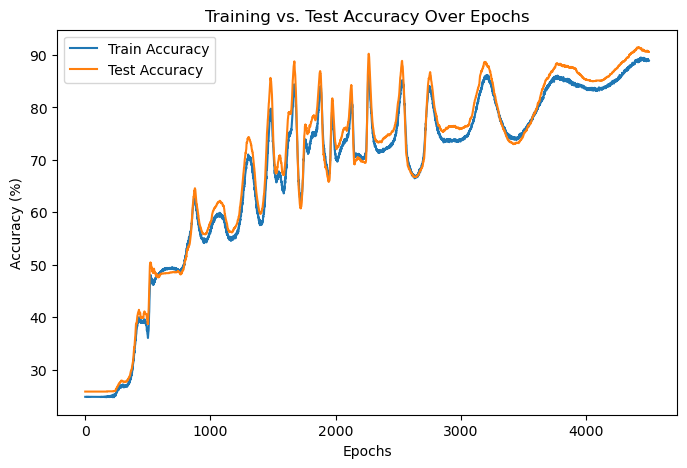

In [185]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, test_accuracies)

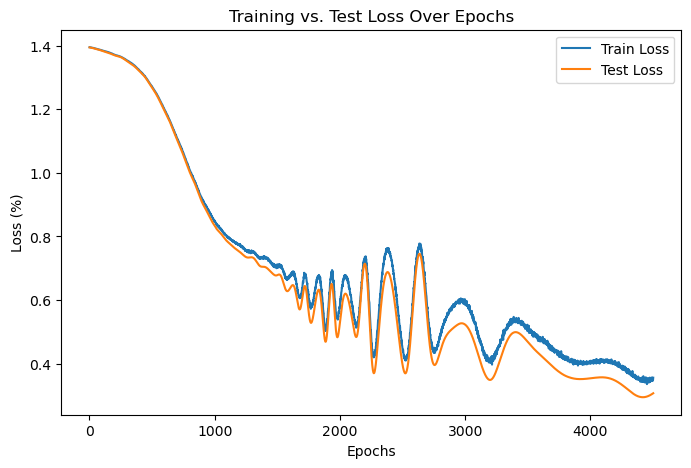

In [187]:
# Do not change this cell
plot_loss_performance(train_losses, test_losses)

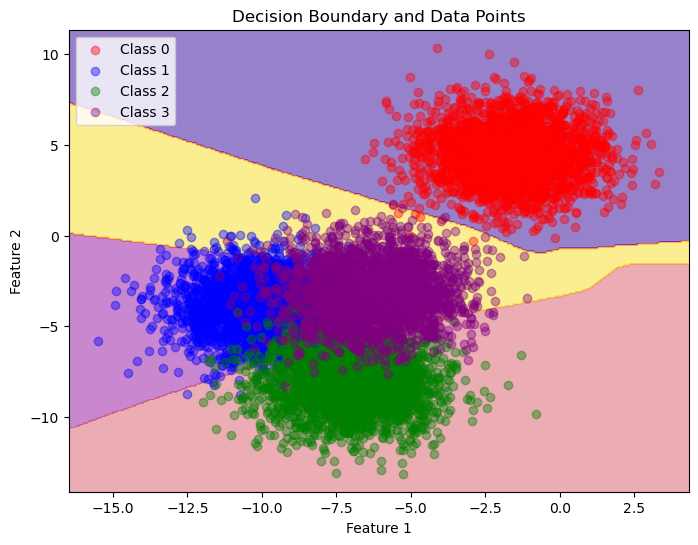

In [189]:
# Do not change this cell
plot_decision_boundary(model, X_train, y_train)